# Using Intel oneMKL PARDISO as an external sparse direct solver for PyFVTool

MW 250721

This is an example of how to use an external sparse solver via a PyFVTool interface.

An external solver can be supplied as an optional argument to `pyfvtool.solvePDE()`, *e.g.*

```python
pf.solvePDE(phi, eqnterms,
            externalsolver = solveur)
```

where `solveur` is a function that will be called instead of `scipy.sparse.linalg.spsolve(A, b)`. It should provide the same interface as the original `spsolve`.

In this example, we use `pyfvtool.solvers.oneMKL_pardiso.spsolve_oneMKL_pardiso(A, b)`.

## PyFVTool MKL PARDISO interface

PyFVTool includes a minimal interface to the [Intel oneMKL PARDISO solver](https://www.intel.com/content/www/us/en/docs/onemkl/developer-reference-c/2023-2/onemkl-pardiso-parallel-direct-sparse-solver-iface.html)

Beyond `numpy`, `scipy` and `matplotlib`, it requires that the Intel oneMKL runtime (package `mkl`) be installed in the PyFVTool environment. On Windows, this may already be the case, since NumPy already depends on it, but we found that it needs to be installed explicitly on our Linux system:

```
conda install mkl
```

## Test drive the solver

In [1]:
import sys
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
from pyfvtool.solvers.oneMKL_pardiso import spsolve_oneMKL_pardiso

# additional import to get MKL version printed
from pyfvtool.solvers.oneMKL_pardiso import oneMKL_pardiso_solver_instance

In [3]:
print('Python', sys.version)
print('NumPy version          : ', np.__version__)
print('SciPy version          : ', sp.__version__)
print('oneMKL runtime version : ', oneMKL_pardiso_solver_instance.get_MKL_version_string())

Python 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:29:09) [MSC v.1943 64 bit (AMD64)]
NumPy version          :  2.3.1
SciPy version          :  1.16.0
oneMKL runtime version :  2024.0.2


In [4]:
A = sparse.rand(10, 10, density=0.5, format='csr')

In [5]:
b = np.random.rand(10)

In [6]:
x = spsolve_oneMKL_pardiso(A, b)

In [7]:
x

array([-1.20211002,  1.05051276, -6.83095628, -0.48208505, -5.01440707,
        2.15586899, -7.49074906,  4.64167887, 13.99052384, -0.81474405])

## PyFVTool finite-volume (from cylindrical2D_convection notebook)

In [8]:
from time import time
import pyfvtool as pf

#### Utility functions

In [9]:
# visualization routine (imshow-based)
def phi_visualize():
    print(f't = {t:.1f} s')
    # avoid ghost cells
    plt.imshow(phi.value, origin = 'lower',
               extent = [zz[0], zz[-1], rr[0]*rzoom, rr[-1]*rzoom])

In [10]:
# calculate simple finite-volume integral over r
def integral_dr(phi0):
    v = phi0.cellvolume
    c = phi0.value
    return (v*c).sum(axis=0)

#### FVM settings

In [11]:
Lr = 7.5e-05 # [m] radius of cylinder
Lz = 0.3 # [m] length of cylinder
umax = 2*9.4314e-3 # [m s^-1] max flow velocity = 2 time average flow velocity

In [12]:
# regular grid parameters
Nr = 40
Nz = 500

In [13]:
# initial condition parameters (cell indices)
loadix0 = 20
loadix1 = 40

In [14]:
# timestep parameters
deltat = 0.01 # [s] per time step

In [15]:
# visualization parameters
rzoom = 1000

#### 2D cylindrical mesh

In [16]:
msh = pf.CylindricalGrid2D(Nr, Nz, Lr, Lz)

#### Set up Poiseuille flow velocity field

In [17]:
rr = msh.cellcenters.r
zz = msh.facecenters.z

In [18]:
uu =  umax*(1 - (rr**2)/(Lr**2)) # does not depend on zz

In [19]:
u =  pf.FaceVariable(msh, 1.0)

In [20]:
u.rvalue[:] = 0
u.zvalue[:] = uu[:, np.newaxis]

#### Solution variable

In [21]:
bc = pf.BoundaryConditions(msh)

In [22]:
phi = pf.CellVariable(msh, 0.0 , bc)

#### Initial condition

In [23]:
t=0.

In [24]:
# initial condition
for i in range(loadix0, loadix1):
    phi.value[:, i] = 1.0

t = 0.0 s


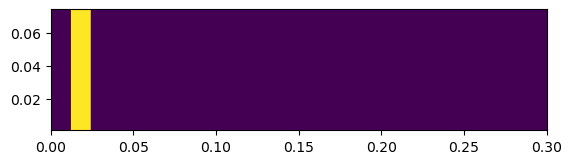

In [25]:
phi_visualize()

In [26]:
initInt = phi.domainIntegral()
# print(initInt)

In [27]:
phiprofs = []
phiprofs.append((t, integral_dr(phi)))

### Solve the convection PDE with time-stepping

In [28]:
exect0 = time()

In [29]:
# The convection term only needs to be constructed once, since it
# will be constant during all time steps.
# convectionterm = pf.convectionTerm(u) # really ugly results?
convectionterm = pf.convectionUpwindTerm(u) # numerical diffusion

def step_solver(Nstp):
    global t

    for i in range(Nstp):
        # Transient term needs to be re-evaluated at each time step
        transientterm = pf.transientTerm(phi, deltat, 1.0)
        eqnterms = [transientterm,
                    convectionterm]
        # solve the PDE using oneMKL PARDISO as the external solver,
        #    via `spsolve_oneMKL_pardiso`
        pf.solvePDE(phi, eqnterms,
                    externalsolver = spsolve_oneMKL_pardiso)
        t += deltat

In [30]:
step_solver(200)
phiprofs.append((t, integral_dr(phi)))

In [31]:
# print(t, initInt, pf.domainInt(phi))
# test conservation of mass
assert np.isclose(initInt, phi.domainIntegral())

t = 2.0 s


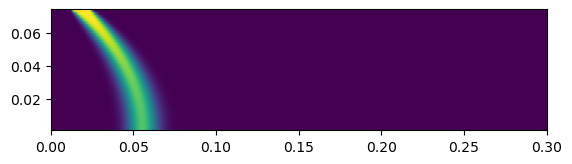

In [32]:
phi_visualize()

In [33]:
step_solver(300)
phiprofs.append((t, integral_dr(phi)))

In [34]:
step_solver(500)
phiprofs.append((t, integral_dr(phi)))

In [35]:
print(t, initInt, phi.domainIntegral())

9.999999999999831 2.1205750411731096e-10 2.1205750411730108e-10


t = 10.0 s


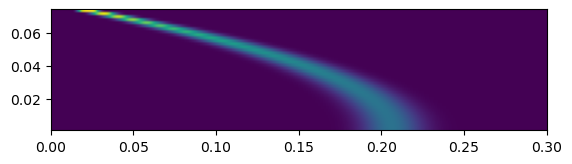

In [36]:
phi_visualize()

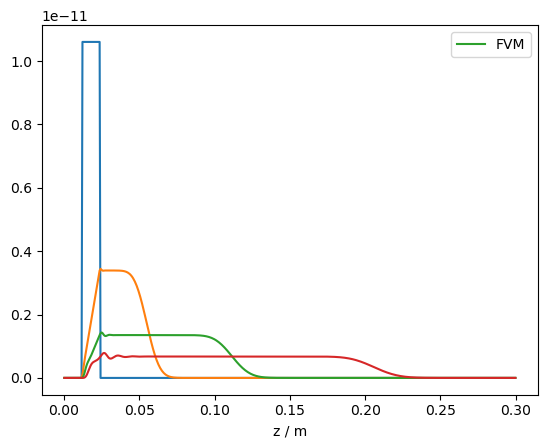

In [37]:
for ix, (tprof, phiprof) in enumerate(phiprofs):
    if ix == 2:
        lbl1 = 'FVM'
    else:
        lbl1 = None
    plt.plot(phi.domain.cellcenters.z, phiprof, 
             label=lbl1)
plt.xlabel('z / m')
plt.legend();

In [38]:
exect1 = time()

In [39]:
print('Elapsed time ', exect1 - exect0, 's')

Elapsed time  17.19912052154541 s
